<a href="https://colab.research.google.com/github/DJCordhose/ml-resources/blob/main/notebooks/cv/faces-cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning approach to facial emotion detection

## Getting and preprocessing faces data

* https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/data
* https://www.kaggle.com/datasets/msambare/fer2013
* https://blog.devgenius.io/facial-expression-recognition-with-tensorflow-90f6174163c3
  * https://github.com/joaopdss/FacialExpressionRecognition/blob/main/Facial_expression_recognition%20.ipynb

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (20, 8)
mpl.rcParams['axes.titlesize'] = 24
mpl.rcParams['axes.labelsize'] = 20

In [2]:
import numpy as np
np.__version__

'1.21.6'

In [3]:
import pandas as pd
pd.__version__

'1.3.5'

In [4]:
from google.colab import drive
import sys

drive_folder = "/content/drive/MyDrive/public"

if 'google.colab' in sys.modules:
  drive.mount("/content/drive")
  !cp {drive_folder}/data/fer2013.tar.gz .
  !tar -xzvf fer2013.tar.gz
  FER2013_CSV_PATH = "./fer2013/fer2013.csv"
else:
  FER2013_CSV_PATH = "/home/olli/cv/fer2013/fer2013.csv"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
fer2013/fer2013.csv
fer2013/README
fer2013/fer2013.bib
fer2013/


In [5]:
!ls -l {drive_folder}/data

total 155944
-rw------- 1 root root 96433867 Oct 13 08:10 fer2013.tar.gz
-rw------- 1 root root 63252113 Oct 24 08:33 fer2013.zip


In [6]:
df = pd.read_csv(FER2013_CSV_PATH)
df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [7]:
label_names = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]

In [8]:
df["emotion"].value_counts()

3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64

In [9]:
def plot_data(data, classes):
  
  values = data["emotion"].value_counts().sort_index(ascending=True)

  plt.bar(x=classes, height=values, edgecolor='black')

  plt.xlabel("Emotions")
  plt.ylabel("Amount")
  plt.title("Amount of emotions")
  plt.show();

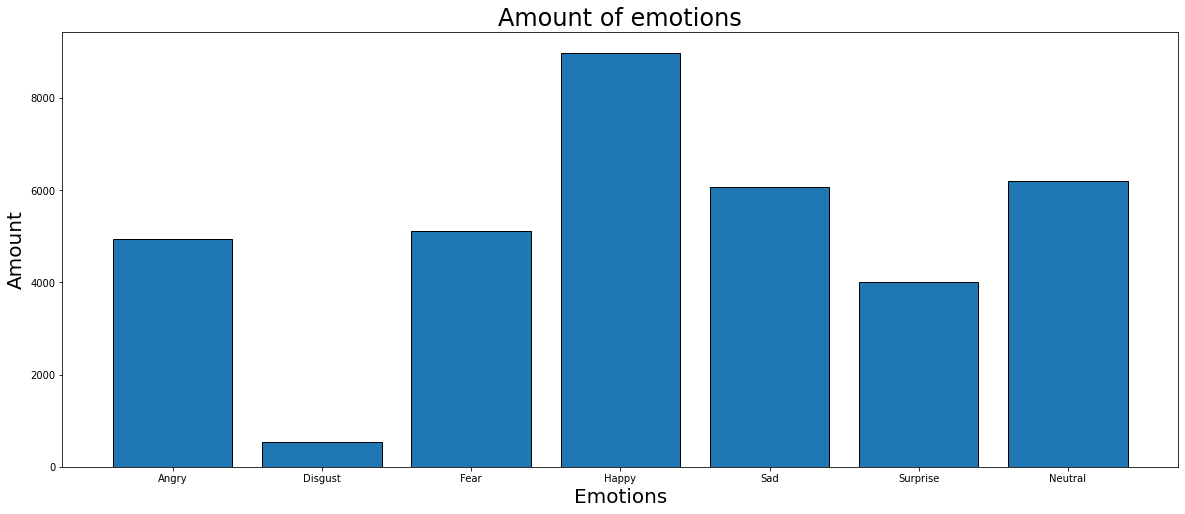

In [10]:
plot_data(df, label_names)

taking advice from 

https://github.com/joaopdss/FacialExpressionRecognition/blob/main/Facial_expression_recognition%20.ipynb

we leave out fear and disgust because they are hard to produce, plus disgust has few samples only

In [11]:
filtered_df = df[df["emotion"].isin([0, 3, 4, 5, 6, 7])] 

In [12]:
# now some labels just don't have a samples, we shift all lables to the left

filtered_df["emotion"].value_counts()

3    8989
6    6198
4    6077
0    4953
5    4002
Name: emotion, dtype: int64

In [13]:
filtered_label_names = ["Angry", "Happy", "Sad", "Surprise", "Neutral"]

In [14]:
# pandas again makes this impossible to get right without stack overflow
# this does work even though we can an error
filtered_df.loc[filtered_df["emotion"] == 3, "emotion"] = 1
filtered_df.loc[filtered_df["emotion"] == 4, "emotion"] = 2
filtered_df.loc[filtered_df["emotion"] == 5, "emotion"] = 3
filtered_df.loc[filtered_df["emotion"] == 6, "emotion"] = 4

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [15]:
filtered_df["emotion"].value_counts()

1    8989
4    6198
2    6077
0    4953
3    4002
Name: emotion, dtype: int64

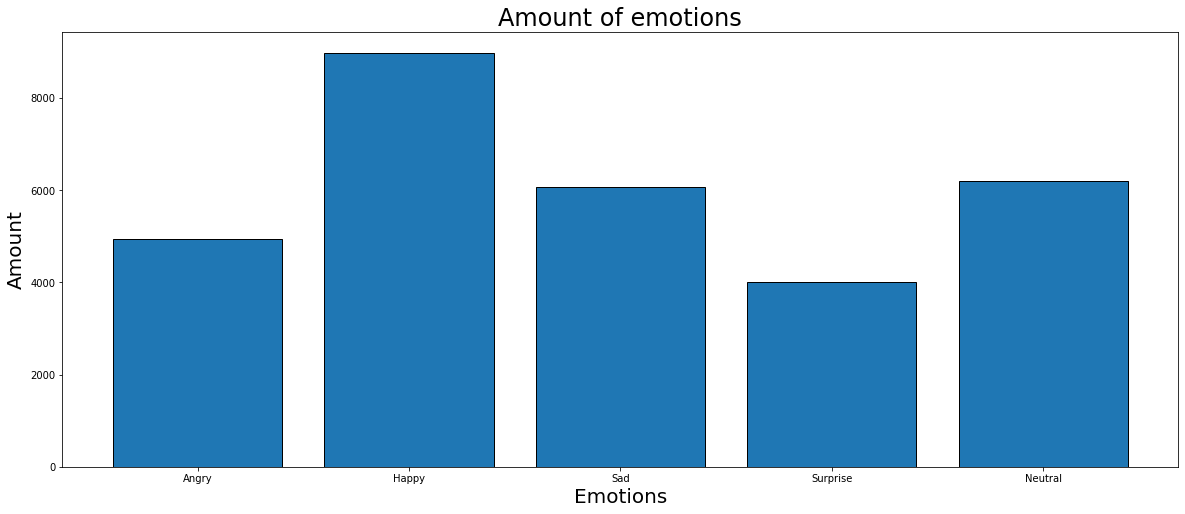

In [16]:
plot_data(filtered_df, filtered_label_names)

In [17]:
df = filtered_df

In [18]:
pixels = df["pixels"]
len(pixels)

30219

In [19]:
resolution = (48, 48)
def image_from_pixels(pixels):
    image = np.reshape(np.array(pixels.split(), 'float64'), resolution)
    return image

In [20]:
%%time

images = np.array([image_from_pixels(p) for p in pixels])
images.shape

CPU times: user 8.34 s, sys: 315 ms, total: 8.65 s
Wall time: 8.62 s


(30219, 48, 48)

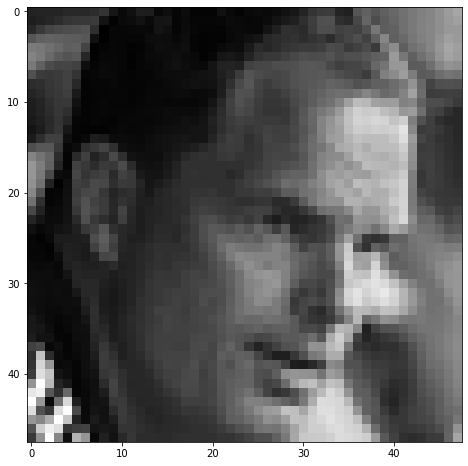

In [21]:
plt.imshow(images[100], cmap='gray');

In [22]:
labels = df["emotion"].values

In [23]:
labels.shape

(30219,)

In [24]:
X = images
y = labels

In [25]:
def plot_gallery(X, y, label_names, size=15):

    population = X.shape[0]
    if size and size < population:
        samples = np.random.choice(population, size=size, replace=False)
    else:
        # just all
        samples = np.arange(0, population)

    for idx, i in enumerate(samples):
        ax = plt.subplot(3, 5, idx + 1)
        image = X[i]
        plt.imshow(image, cmap='gray')
        y_true = y[i]
        plt.title(label_names[y_true])
        plt.axis("off")

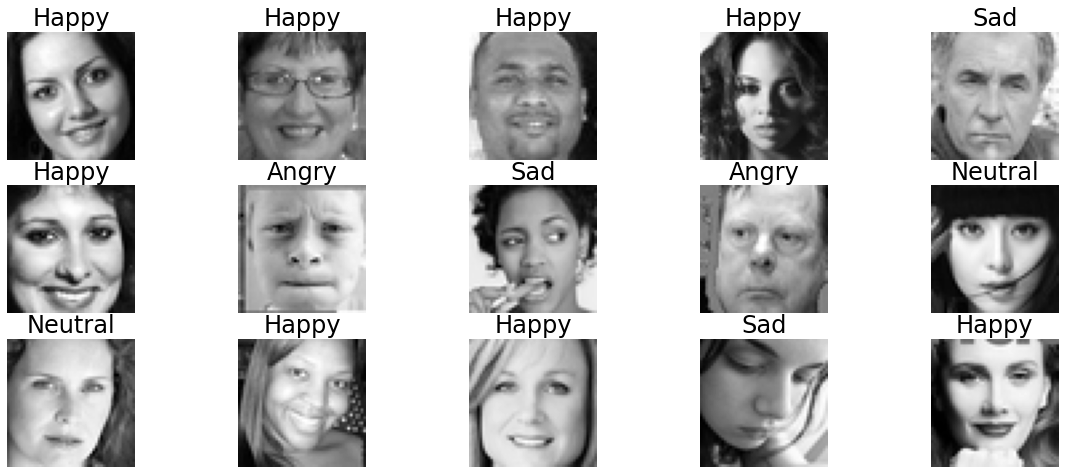

In [26]:
plot_gallery(X, y, filtered_label_names)

## Preparing Training

In [27]:
images.shape, images.dtype

((30219, 48, 48), dtype('float64'))

In [28]:
# images encoded as 0..255 bit maps
# neural networks can deal with bytes, but like floats close to 0 better
images.max(), images.min()

(255.0, 0.0)

In [29]:
# sometimes numpy is just great: broadcast
images_normlized = images / 255.0

# we also need to expand images, as the prebuild networks expect that
images_normlized = np.expand_dims(images_normlized, axis=-1)

In [30]:
images_normlized.shape, images_normlized.dtype, images_normlized.max(), images_normlized.min()

((30219, 48, 48, 1), dtype('float64'), 1.0, 0.0)

In [31]:
# our default tools are still flexible enough to work with this
# (or not as the version of matplotlib running on colab)

# plot_gallery(images_normlized, y, label_names)

In [32]:
input_shape=(48, 48, 1)

In [33]:
np.unique(labels)

array([0, 1, 2, 3, 4])

In [34]:
num_classes = labels.max() + 1
num_classes

5

## What kind of model should we use?

* Coming up with a decent CNN architecture is a research topic
* Using a prebuilt architecture often is the best choice
  * https://keras.io/api/applications/
  * having a lot of good training data, can make additional regularization unnecessary
  * it can be done, though, but not trivially: https://sthalles.github.io/keras-regularizer/
* however, accuracy is not the only metric we are concerned about
  * we also need this to be portable to run in the browser in the first place, plus
  * we need this to react in near real time to be useable
  * training any default architecture on CPU is simply not feasible
  * do we have a GPU availble for training 
  * which one, how powerful?

In [35]:
import tensorflow as tf
tf.__version__

'2.9.2'

In [36]:
!nvidia-smi

Wed Oct 26 22:30:05 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    45W / 400W |      0MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [37]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [38]:
# use_custom_model = True
use_custom_model = False

In [39]:
from tensorflow.keras.layers import InputLayer, Dense, Conv2D, MaxPooling2D, Dropout, BatchNormalization, Flatten

model = tf.keras.Sequential()

model.add(InputLayer(input_shape=input_shape, name='input'))

model.add(Conv2D(filters=32, kernel_size=3, activation='relu')) 
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization())
model.add(Dropout(0.7))

model.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization())
model.add(Dropout(0.7))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.7))
model.add(Dense(num_classes, activation='softmax'))

In [40]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

if not use_custom_model:
  # model = ResNet50(weights='imagenet')
  model = ResNet50(weights=None, input_shape=input_shape, classes=num_classes)

In [41]:
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 48, 48, 1)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 54, 54, 1)    0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 24, 24, 64)   3200        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 24, 24, 64)   256         ['conv1_conv[0][0]']             
                                                                                           

0

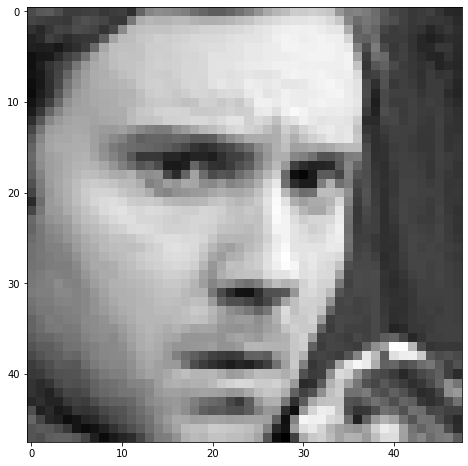

In [42]:
# labels: "Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"
img = images[0]
plt.imshow(img, cmap='gray');
labels[0]

In [43]:
# From docs: The images are converted from RGB to BGR, then each color channel is 
# zero-centered with respect to the ImageNet dataset, without scaling.

# preprocess_input?

In [44]:
# this is what ImageNet dataset looks like, but for the rest of the world this is just weird
# so let's not do this
x = preprocess_input(img.copy())
x.shape, x.dtype, x.min(), x.max()

((48, 48), dtype('float64'), -84.68, 210.0)

In [45]:
X = images_normlized
y = labels

In [46]:
# we play be our own rules, we do our own split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=21, stratify=y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((27197, 48, 48, 1), (3022, 48, 48, 1), (27197,), (3022,))

In [47]:

model.compile(loss='sparse_categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

In [48]:
# https://github.com/AndreasMadsen/python-lrcurve
import sys

if 'google.colab' in sys.modules:
  !pip install -q lrcurve

In [49]:
# inspiration from: https://github.com/joaopdss/FacialExpressionRecognition/blob/main/Facial_expression_recognition%20.ipynb

from tensorflow.keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau()

In [50]:
model.fit?

In [51]:
%%time

from lrcurve import KerasLearningCurve

BATCH_SIZE = 50
# EPOCHS = 500

# Resnet50
# - 30 min on T4
# - 18 min on A100
# - < 15 min on V100
EPOCHS = 75
# EPOCHS = 50

history = model.fit(X_train, y_train, 
                    epochs=EPOCHS, 
                    batch_size=BATCH_SIZE, 
                    shuffle=True,
                    validation_data=(X_test, y_test),
                    # validation_split=0.1,
                    callbacks=[reduce_lr, KerasLearningCurve()],
                    verbose=0
                    )

CPU times: user 20min 17s, sys: 26.6 s, total: 20min 44s
Wall time: 18min 46s


## Evaluating results

In [52]:
train_loss, train_accuracy = model.evaluate(X_train, y_train, batch_size=BATCH_SIZE, verbose=0)
train_loss, train_accuracy

(0.005700977519154549, 0.9991543292999268)

In [53]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=BATCH_SIZE, verbose=0)
test_loss, test_accuracy

(3.1636624336242676, 0.6499007344245911)

In [54]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_cm(model, X, y, file_name=None, label_names=label_names):
    y_pred = model.predict(X, batch_size=BATCH_SIZE).argmax(axis=1)
    cm = confusion_matrix(y, y_pred)
    figure = plt.figure(figsize=(10, 10))

    sns.heatmap(cm, annot=True, xticklabels=label_names, yticklabels=label_names, cmap='Blues', fmt='d')
    if file_name:
        plt.savefig('outputs/%s.png' % file_name)

In [55]:
def plot_accuracy(history, file_name=None):
    plt.figure()
    plt.xlabel('epochs')
    plt.ylabel('accuracy')

    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.legend(['Accuracy', 'Validation Accuracy']);
    if file_name:
        plt.savefig('outputs/%s.png' % file_name)

In [56]:
def plot_loss(history, file_name=None):
    plt.figure()

    plt.xlabel('epochs')
    plt.ylabel('loss')

    plt.yscale('log')

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.legend(['Loss', 'Validation Loss']);
    if file_name:
        plt.savefig('outputs/%s.png' % file_name)

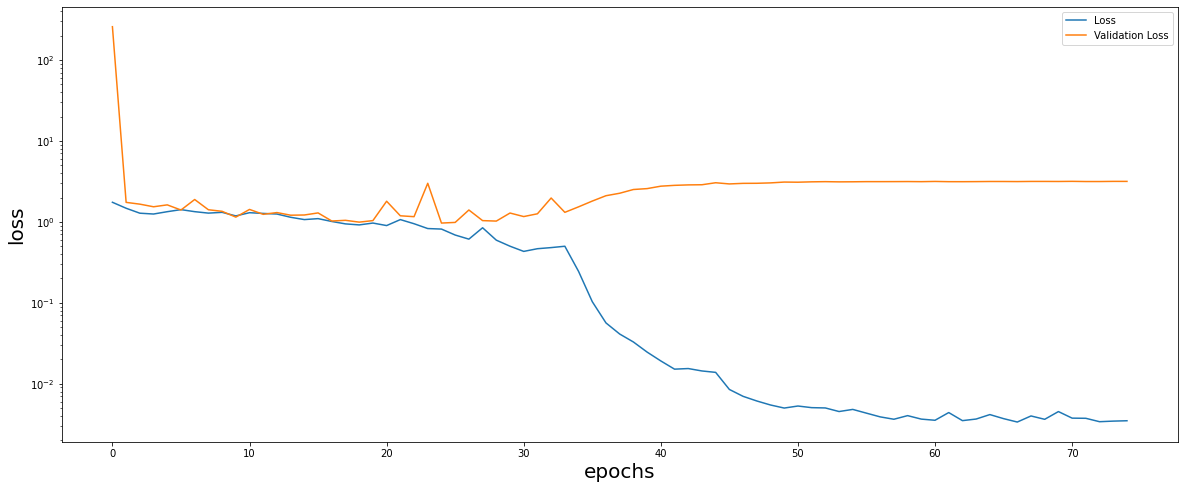

In [57]:
plot_loss(history)

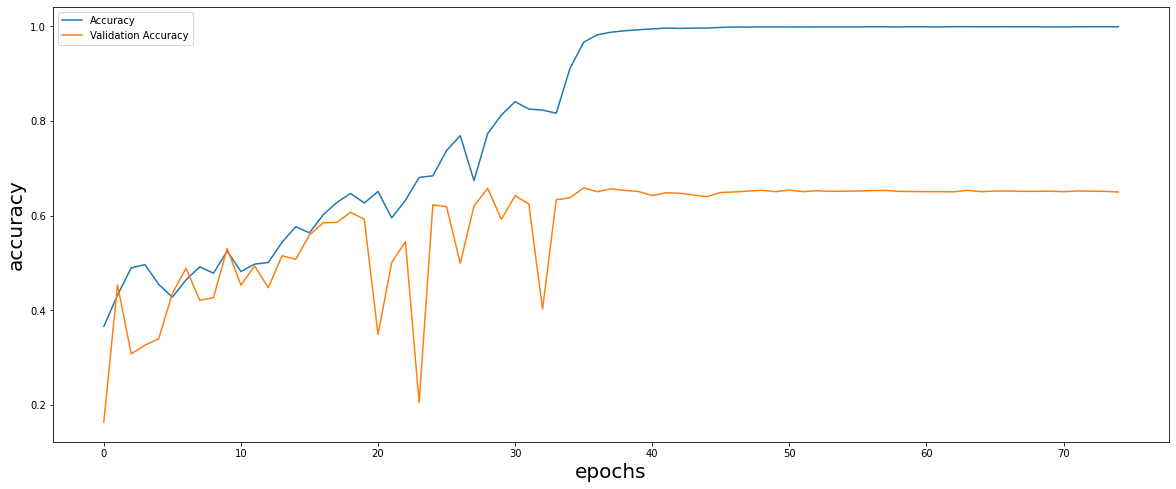

In [58]:
plot_accuracy(history)

544/544 [==============================] - 6s 9ms/step


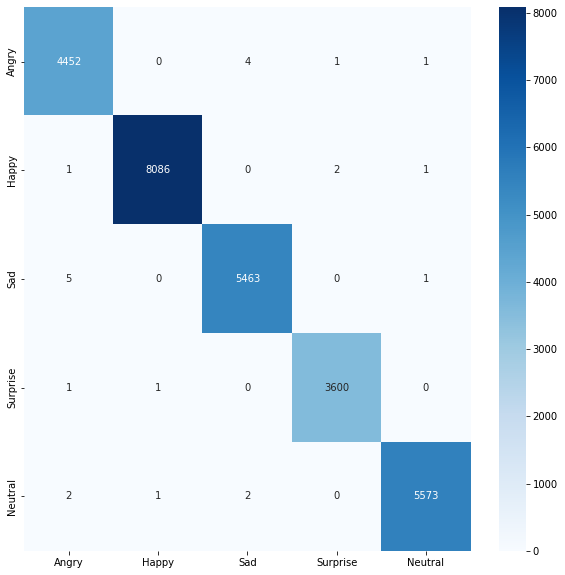

In [59]:
plot_cm(model, X_train, y_train, label_names=filtered_label_names)

61/61 [==============================] - 1s 8ms/step


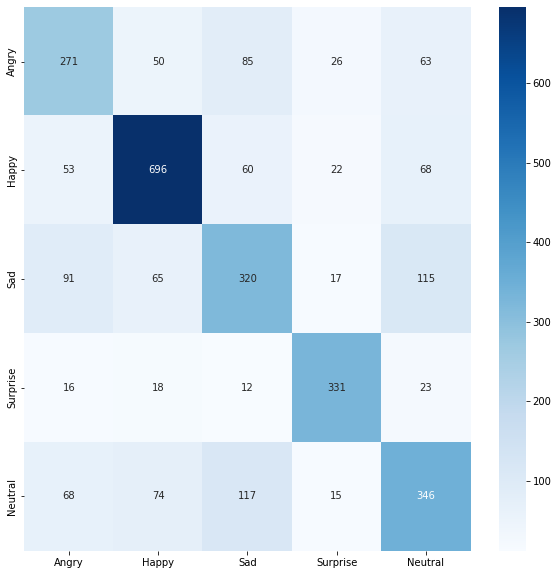

In [60]:
plot_cm(model, X_test, y_test, label_names=filtered_label_names)

## Saving model

In [61]:
if use_custom_model:
  model_name = 'simple-vgg.h5'
else:
  model_name = 'resent50.h5'
model.save(model_name)

In [62]:
!ls -l

total 371244
drwx------ 6 root   root      4096 Oct 26 22:11 drive
drwxr-x--- 2 204241 5762      4096 Jul 10  2013 fer2013
-rw------- 1 root   root  96433867 Oct 26 22:29 fer2013.tar.gz
-rw-r--r-- 1 root   root 283704376 Oct 26 22:49 resent50.h5
drwxr-xr-x 1 root   root      4096 Oct 25 13:35 sample_data


In [63]:
!cp {model_name} {drive_folder}/model

In [64]:
!ls -l {drive_folder}/model

total 296578
-rw------- 1 root root 283704376 Oct 26 22:49 resent50.h5
-rw------- 1 root root  19990344 Oct 26 21:33 simple-vgg.h5
